In [2]:
path = "/notebooks/notebooks/GearDetection"

In [3]:
!pip install opencv-contrib-python==4.1.2.30

Looking in indexes: https://pypi.python.org/simple/
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import os
import glob
import numpy as np
import cv2
from sklearn.utils import shuffle
from mosaicml import *
from mosaicml.constants import MLModelFlavours
from werkzeug.datastructures import FileStorage

def load_data(img_path, image_size, classes):
    images = []
    labels = []
    ids = []
    cls = []

    print('Reading training images')
    for fld in classes:  # assuming data directory has a separate folder for each class, and that each folder is named after the class
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(img_path, fld, '*p')
        files = glob.glob(path)
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            ids.append(flbase)
            cls.append(fld)
    images = np.array(images)
    labels = np.array(labels)
    ids = np.array(ids)
    cls = np.array(cls)

    return images, labels, ids, cls


class DataSet(object):
    def __init__(self, images, labels, ids, cls):
        """Construct a DataSet. one_hot arg is used only if fake_data is true."""

        self._num_examples = images.shape[0]

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        # Convert from [0, 255] -> [0.0, 1.0].

        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)

        self._images = images
        self._labels = labels
        self._ids = ids
        self._cls = cls
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def ids(self):
        return self._ids

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed


def read_data_sets(data_path, image_size, classes, portion_size):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, ids, cls = load_data(data_path, image_size, classes)
    images, labels, ids, cls = shuffle(images, labels, ids, cls)  # shuffle the data

    if isinstance(portion_size, float):
        test_size = int(portion_size * images.shape[0])

    test_images = images[:test_size]
    test_labels = labels[:test_size]
    test_ids = ids[:test_size]
    test_cls = cls[:test_size]

    train_images = images[test_size:]
    train_labels = labels[test_size:]
    train_ids = ids[test_size:]
    train_cls = cls[test_size:]

    data_sets.train = DataSet(train_images, train_labels, train_ids, train_cls)
    data_sets.test = DataSet(test_images, test_labels, test_ids, test_cls)

    return data_sets

Using TensorFlow backend.
/home/mosaic-ai/.pyenv/versions/3.6.2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mosaic-ai/.pyenv/versions/3.6.2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mosaic-ai/.pyenv/versions/3.6.2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mosai

In [5]:
import cv2
import glob
import numpy as np
import time
import os

def rescale_img(image):
    # we need to keep in mind aspect ratio so the image does
    # not look skewed or distorted -- therefore, we calculate
    # the ratio of the new image to the old image
    r = 1600.0 / image.shape[1]
    dim = (1600, int(image.shape[0] * r))

    # perform the actual resizing of the image and show it
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized

def crop_img(category):

    j = 0
    source_file = "/notebooks/notebooks/GearDetection/"+ category + "/*.bmp"
    destination_file = "/notebooks/notebooks/GearDetection/prepro_data/"+category+"/"+category

    for img in glob.glob(source_file):
        orig_img = cv2.imread(img)
        start_time = time.time()
        im = rescale_img(orig_img)
        orig_img = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        (thresh, im_bw) = cv2.threshold(orig_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        kernel = np.ones((4, 4), np.uint8)
        closing = cv2.morphologyEx(im_bw, cv2.MORPH_CLOSE, kernel)
        kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel2)

        (_, cnts, _) = cv2.findContours(opening.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        i = 0

        list_coordx = []
        list_coordy = []
        list_coordw = []
        list_coba = []
        for c in cnts:
            x, y, w, h = cv2.boundingRect(c)
            if x > 450 and x < 1100:
                if (w > 120 and h > 135) and (w < 160 and h < 200):
                    if w / h >= 0.65 and w / h <= 1:
                        roi = im[y:y + h, x:x + w]
                        list_coordx.append(x)
                        list_coordy.append(y)
                        list_coordw.append(w)
                        list_coba.append((x, y, h))
                        i = i + 1

        if (i != 4):
            print("Error..............................................................")
        height, width, channels = im.shape
        test = sorted(list_coba)
        xmax = max(list_coordx)
        xmin = min(list_coordx)
        ymax = max(list_coordy)
        ymin = min(list_coordy)
        wmax = max(list_coordw)

        if test[0][1] < test[1][1]:
            hmax = test[1][2]
        else:
            hmax = test[0][2]

        a = ymax + hmax - ymin + 40

        b = int((a - xmax - wmax + xmin) / 2)
        c = xmax + wmax + 2 * b - xmin
        if (a != c):
            new_cropped = im[(ymin - 20):(ymax + hmax) + 19, (xmin - b):(xmax + wmax) + b]
        else:
            new_cropped = im[(ymin - 20):(ymax + hmax) + 20, (xmin - b):(xmax + wmax) + b]

        tinggi, lebar, channels = new_cropped.shape
        end_time_str = " %s s" % round((time.time() - start_time), 3)

        cv2.imwrite(destination_file +"-"+ str(j) + ".bmp", new_cropped)
        print("saving to", destination_file + "-" + str(j) + ".bmp")
        print("completed created in ", end_time_str)
        j = j + 1

    print("saving data "+ category + " completed")
    

In [6]:
!pip install matplotlib
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

Looking in indexes: https://pypi.python.org/simple/
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
def cnn_model(data, img_size):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.summary()

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(data.train.images, data.train.labels, validation_split=0.16, batch_size=1, epochs=50, verbose=1)

    return model, history

In [8]:
def summary_result(data_act, data_pred):

    cm = confusion_matrix(data_act, data_pred)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Defect', 'Non-defect']
    plt.title('Confusion Matrix of Defect and Non-defect Classification')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN', 'FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(s[i][j]) + " = " + str(cm[i][j]))
    plt.show()

    # calculate AUC
    auc = roc_auc_score(data_act, data_pred)
    print('AUC score = %.3f' % auc)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(data_act, data_pred)

    # plot no skill
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

    acc = accuracy_score(data_act, data_pred)
    print("Accuracy score = ", acc)

In [9]:
img_size = 256
class_list = ['defect', 'non_defect']
data_path = '/notebooks/notebooks/GearDetection'
checkpoint_dir = "/notebooks/notebooks/GearDetection"

data = read_data_sets(data_path, img_size, class_list, portion_size=0.25)

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Testing-set:\t\t{}".format(len(data.test.labels)))

Reading training images
Loading defect files (Index: 0)
Loading non_defect files (Index: 1)
Size of:
- Training-set:		150
- Testing-set:		50


In [10]:
model, history = cnn_model(data, img_size)








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 127, 127, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 62, 64)        256       
____________________

126/126 [==============================] - 11s 91ms/step - loss: 1.4306e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 20/50
126/126 [==============================] - 12s 96ms/step - loss: 2.0609e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 21/50
126/126 [==============================] - 12s 95ms/step - loss: 1.8905e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 22/50
126/126 [==============================] - 11s 91ms/step - loss: 1.6167e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 23/50
126/126 [==============================] - 11s 91ms/step - loss: 1.9743e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 24/50
126/126 [==============================] - 12s 91ms/step - loss: 4.2394e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 25/50
126/126 [==============================] - 11s 91ms/step - loss: 1.1809e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 26/50

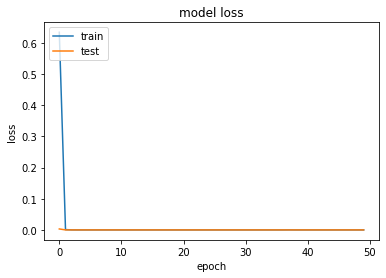

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

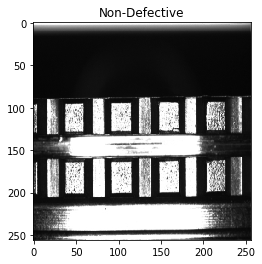

In [12]:
import numpy as np
from matplotlib import pyplot as plt

pred = model.predict_classes(np.array([data.train.images[0]]))
if pred[0] == 1:
    value = "Non-Defective"
elif pred[0] == 0:
    value = "Defective"
plt.title(value)
plt.imshow(data.train.images[0], interpolation='nearest')
plt.show()

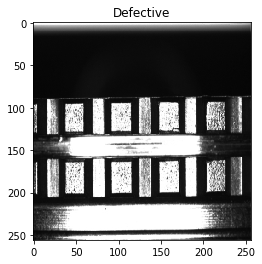

In [13]:
import numpy as np
from matplotlib import pyplot as plt

pred = model.predict_classes(np.array([data.train.images[21]]))
if pred[0] == 1:
    value = "Non-Defective"
elif pred[0] == 0:
    value = "Defective"
plt.title(value)
plt.imshow(data.train.images[0], interpolation='nearest')
plt.show()

In [14]:
@scoring_func
def score(model, request):
    image_size = 256
    image = FileStorage(request.files['file1'])
    image.save("image.bmp")
    
    image = cv2.imread("image.bmp")
    image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
    images = np.array(image)

    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)
    pred = model.predict_classes(np.array([images]))
    if pred[0] == 1:
        value = "Non-Defective"
    elif pred[0] == 0:
        value = "Defective"
    return ("Prediction : " + value)

In [15]:
import requests
request = requests.Request()
request.files= {"file1" : open('/notebooks/notebooks/GearDetection/defect/defect1.bmp','rb')}
s=score(model,request)
s

'Prediction : Defective'

In [17]:
register_model(model, score, "Gear_Defect_Detection_3", "Gear_Defect_Detection_3", MLModelFlavours.keras, init_script="pip install matplotlib \\n pip install opencv-contrib-python==4.1.2.30")

{'created_by': 'ratan.boddu@lntinfotech.com',
 'created_on': '2019-12-14T11:59:36+00:00',
 'deploymentstatus': False,
 'description': 'Gear_Defect_Detection_3',
 'flavour': 'keras',
 'id': 'ecbdb829-d6f2-4a5d-a895-945cb4a91475',
 'last_modified_by': 'ratan.boddu@lntinfotech.com',
 'last_modified_on': '2019-12-14T11:59:36+00:00',
 'name': 'Gear_Defect_Detection_3',
 'project_id': '86c0d2c2-5996-43e4-addc-8dadc372c625',
 'type': 'model',
 'versions': [{'created_by': 'ratan.boddu@lntinfotech.com',
   'created_on': '2019-12-14T11:59:37+00:00',
   'deploy_info': None,
   'deployments': [],
   'description': None,
   'docker_image_url': 'registry.lti-aiq.in:443/mosaic-ai-logistics/mosaic-ai-serving:1.0.0-52266',
   'id': '10d39901-747a-4512-aaa5-0982d5720db4',
   'init_script': "'pip install absl-py==0.8.1 alembic==1.3.1 astor==0.8.0 async-generator==1.10 attrs==19.3.0 backcall==0.1.0 bleach==3.1.0 blis==0.4.1 cachetools==3.1.1 certifi==2019.11.28 chardet==3.0.4 Click==7.0 cloudpickle==1.2.1